# `Lender-Lender` graphs analysis using `memgraph`

Only for tag `#Vegan`

In [ ]:
from gqlalchemy import Memgraph

memgraph = Memgraph("127.0.0.1", 7687)

# Create the graphs

The schema of data is this

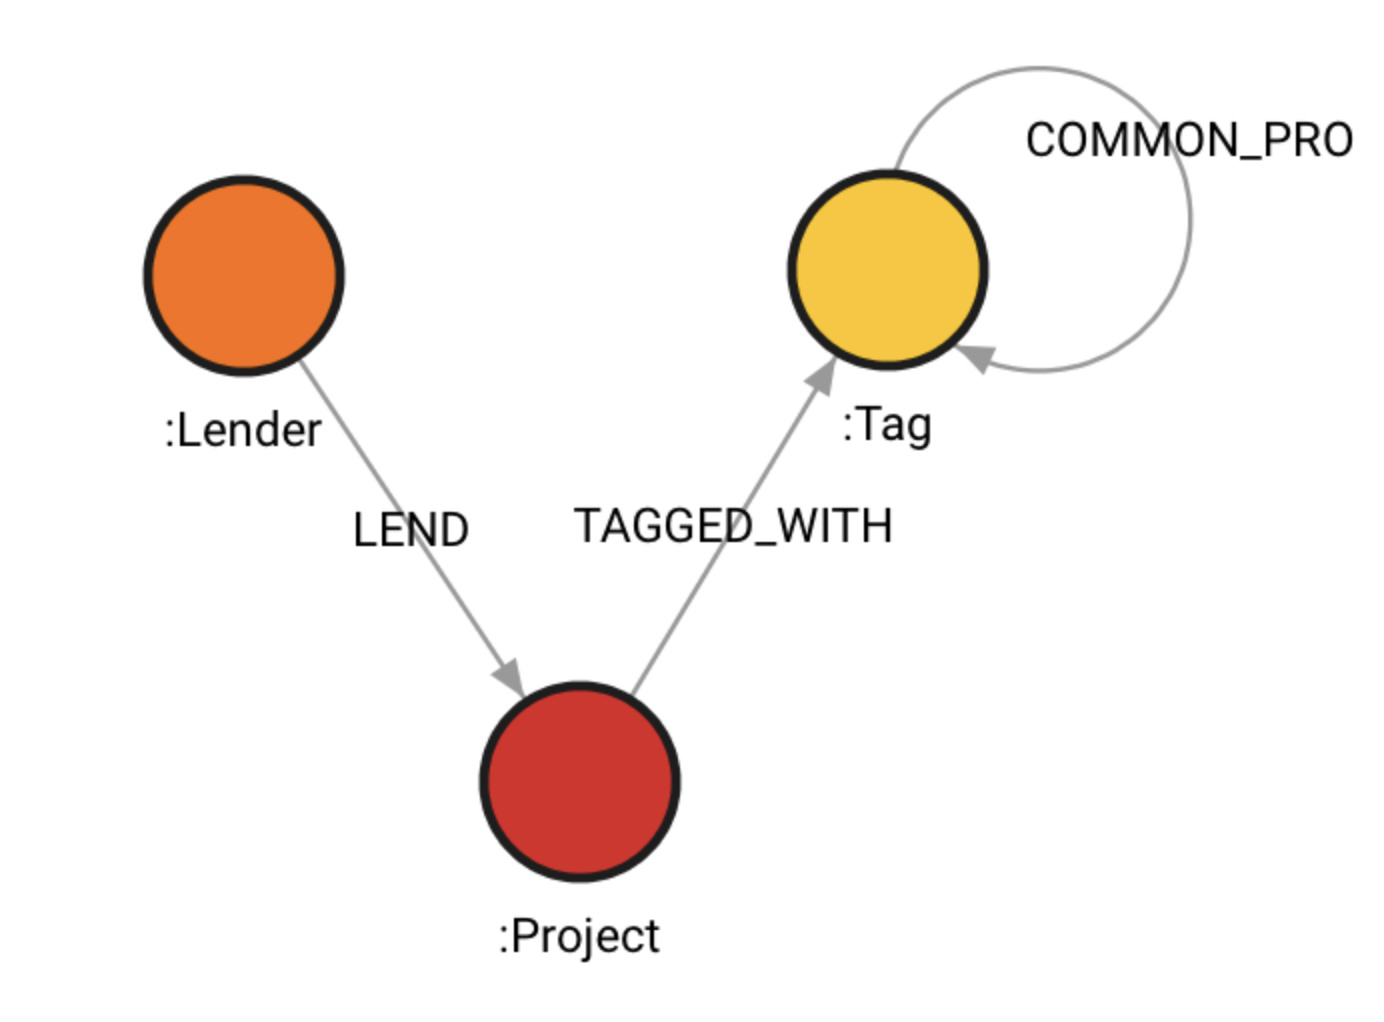

We will create a new `INTEREST` relationship, and then create `Lender-Lender` using that relationship

## Create `INTEREST` relationship

In [ ]:
results = memgraph.execute_and_fetch(
    """
MATCH (lender:Lender)-[:LEND]->(:Project)-[:TAGGED_WITH]->(tag:Tag)
MERGE (lender)-[i:INTEREST]->(tag)
ON CREATE SET i.weight = 1
ON MATCH SET i.weight = i.weight + 1
"""
)
list(results)

After that, we've got

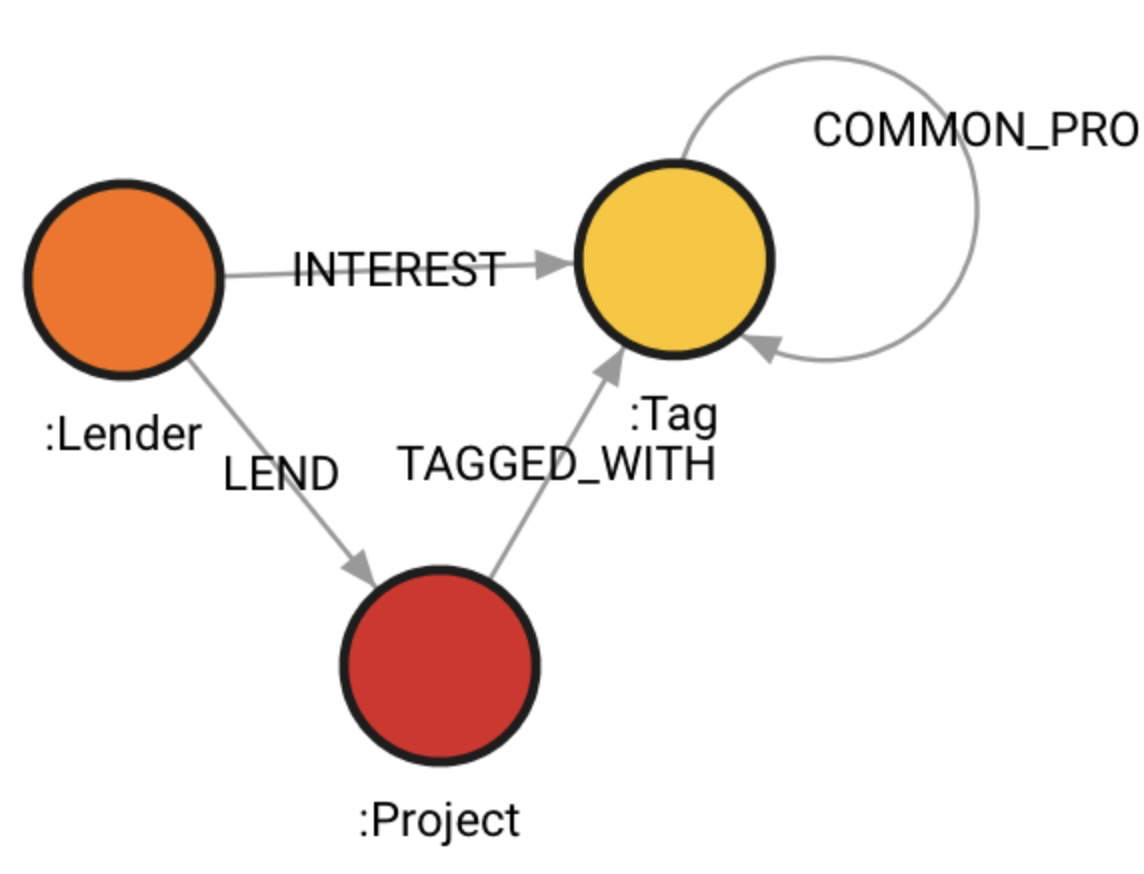

## Create `COMMON_TAG` relationship

Let's define a `normalized similarity` (I made it) weight

$$w = 1 - \frac{|a - b|}{|a| + |b|}$$

In [ ]:
# INTEREST relationship
memgraph.execute(
    """
MATCH (lender:Lender)-[lend:LEND]->(loan:Project)-[t:TAGGED_WITH]->(tag:Tag)
MERGE (lender)-[i:INTEREST]->(tag)
ON CREATE SET i.weight = 1
ON MATCH SET i.weight = i.weight + 1
"""
)

![image.png](attachment:image.png)

In [ ]:
# Create the $F$
memgraph.execute(
    """
MATCH (l1:Lender)-[i1:INTEREST]->(tag1:Tag {name: "#Vegan"})
WITH l1, i1
MATCH p=(l1)-[i2:INTEREST]->(tag2:Tag)
WITH i1, i1.weight * 1.0 / SUM(i2.weight) as f
SET i1.f = f
"""
)

view a result with this commands

```cypher
MATCH (l1:Lender)-[i1:INTEREST]->(tag1:Tag {name: "#Vegan"})
WHERE i1.f = 0.25
WITH l1
LIMIT 1 
MATCH p=(l1)-[:INTEREST]->(:Tag)
RETURN p
```

Style

```text
@EdgeStyle HasProperty(edge, "weight") {
  label: Format("weight={}", Property(edge, "weight"))
}

@EdgeStyle HasProperty(edge, "f") {
  label: Format("weight={} F={}", Property(edge, "weight"), Property(edge, "f"))
}
```

TODO: insert result here

In [ ]:
memgraph.execute(
    """
MATCH p=(l1:Lender)-[i1:INTEREST]->(tag1:Tag {name: "#Vegan"})<-[i2:INTEREST]-(l2:Lender)
WHERE ID(i1) > ID(i2)
UNWIND [i1.weight, i2.weight] as weights
WITH l1, l2, MIN(weights)*(1 - ABS(i1.f - i2.f)/(i1.f + i2.f)) as thew
CREATE (l1)-[:SHARE_VEGAN {weight: thew}]->(l2)
"""
)

## COmmuity

```cypher
MATCH (l:Lender), (:Lender)-[i:SHARE_VEGAN]->(:Lender)
WITH COLLECT(l) as nodes, COLLECT(i) as edges
CALL community_detection.get_subgraph(nodes, edges, "weight")
YIELD node, community_id
SET node.share_vegan_community_id = community_id
```

## First, create the first graph, let's call it `COMMON_PRO`

We would like to do projections, how? Two projections:

- Project the bipartite graph `Project-Tag` on the `Tag`
- Project the bipartite graph `Lender-Tag` on the `Tag`

The weight would be IoU

In [ ]:
results = memgraph.execute_and_fetch(
    """
MATCH (t1:Tag)<-[:TAGGED_WITH]-(p:Project)-[:TAGGED_WITH]->(t2:Tag)
WHERE ID(t1) > ID(t2)
WITH t1, t2, COUNT(DISTINCT p) as intersection_count
CALL {WITH t1 MATCH (p1:Project)-[:TAGGED_WITH]->(t1) RETURN COUNT(DISTINCT p1) as t1pro}
CALL {WITH t2 MATCH (p2:Project)-[:TAGGED_WITH]->(t2) RETURN COUNT(DISTINCT p2) as t2pro}
WITH t1, t2, intersection_count, t1pro + t2pro - intersection_count as union_count, 
      intersection_count * 1.0 / (t1pro + t2pro - intersection_count) as theweight
CREATE (t1)-[i:COMMON_PRO {weight: theweight}]->(t2)
RETURN COUNT(i);
"""
)
list(results)

# TODO: Create `COMMON_LENDER` graph

To do this, first create the `INTEREST` graph, which is a `Lender-Tag` graph.

Then project it to `Tag`, but what is the weight?




# Analysis the `COMMON_PRO` relationship

View the relationship in the memgraph lab

```cypher
MATCH p=(:Tag)-[i:COMMON_PRO]-(:Tag)
RETURN p
```

## Centralarity

Calculate pagerank, then store the ranks in property `common_pro_rank` of each tag node

In [ ]:
results = memgraph.execute_and_fetch(
    """
MATCH p=(:Tag)-[i:COMMON_PRO]-(:Tag)
WITH project(p) AS tagtag
CALL pagerank.get(tagtag) YIELD node, rank
SET node.common_pro_rank = rank
RETURN node.name, rank
ORDER BY rank DESC
"""
)
list(results)

to visualize the pagerank, we should use the memgraph lab again

query:

```cypher
MATCH (t:Tag)
WITH t
ORDER BY t.rank DESC
LIMIT 2
MATCH path=(t)<-[:COMMON_LOANS]-(m:Tag)
RETURN path;
```

Add the following style to the *System Style*. It helps changing the node size based on the rank:

```text
@NodeStyle HasProperty(node, "common_pro_rank") {
  size: Round(Add(Mul(Property(node, "common_pro_rank"), 50), 2))
}
```

## Community finding

## `Louvain` community

In [ ]:
results = memgraph.execute_and_fetch(
    """
MATCH (t:Tag), (:Tag)-[i:COMMON_PRO]->(:Tag)
WITH collect(t) AS nodes,
     collect(i) AS relas
CALL community_detection.get_subgraph(nodes, relas, "weight")
YIELD node, community_id
SET node.common_pro_community_id = community_id
RETURN node.name, community_id
ORDER BY community_id;
"""
)
list(results)

In [ ]:
results = memgraph.execute_and_fetch(
    """
MATCH (t:Tag)
WITH DISTINCT t.community_id as community_id
RETURN count(community_id ) as num_of_clusters;
    """
)
# you will get only 1 result
result = list(results)[0]

# don't forget that results are saved in a dict
print(f"Number of clusters: {result['num_of_clusters']}")

display Tags with community

```
MATCH p=(Tag)-[:COMMON_LOANS]->(:Tag)
RETURN p
```

style change


```
// Cache map to keep a selected color for each community
Define(ColorByInt, AsMap())
Define(GetColorByInt, Function(i, Coalesce(
  Get(ColorByInt, AsText(i)),
  Set(ColorByInt, AsText(i), GetNextColor())
)))

// Feel free to uncomment the lines below to set up a custom style for the specific node property
@NodeStyle HasProperty(node, "community_id") {
  Define(COLOR, GetColorByInt(Property(node, "community_id")))

  color: COLOR
  color-hover: Lighter(COLOR)
  color-selected: Darker(COLOR)
}
```